In [21]:
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt
import pandas as pd
import os
import polars as pl
import toml
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter
from scipy import integrate
from ahrs.filters import Madgwick
from scipy import stats
import toml

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm import tqdm
import seaborn as sns
from ultralytics import YOLO
pio.renderers.default = "vscode"

In [22]:
_pth = toml.load('DATA_PATH.toml')['data_path']['directory']
_pth = os.path.dirname(_pth)
_parent_folder = "paper"
_calib_folder_name = "calibration_00"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)
# _folder_list = os.listdir(_base_pth)[10:15] # forward
# _folder_list = os.listdir(_base_pth)[15:] # sideways
_folder_list = os.listdir(_base_pth)[27:] # spots


_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "spots_rotmat.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)

MOCAP data

In [23]:
m1 = get_rb_marker_name(2)
m4 = get_rb_marker_name(3)
m3 = get_rb_marker_name(4)
m5 = get_rb_marker_name(5)

Getting Sync pulse from Teensy

In [24]:
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):

    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, True, flags= cv2.SOLVEPNP_ITERATIVE)
        
        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
        
        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [25]:
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'mip_p2_60e_noise.pt')
model_pth = os.path.join(os.getcwd(), "..",'models_save', 'mip_ar_200e_noise.pt')
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'best.pt')
yolo_model = YOLO(model_pth)
# model_pth

marker_size = 0.05


In [26]:
results = {'ar_df':[], 'ar_dt':[], 'mc_df':[], 'mc_dt':[], 'time_offset':[], 'folder_name':[]}
for _folder_name in tqdm(_folder_list):
    _teensy_df = pl.read_csv(os.path.join(_base_pth,_folder_name,"imu01.csv"))
    _teensy_df = _teensy_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))
    t_time = _teensy_df["rust_time"].to_numpy()
    t_time = [datetime.fromtimestamp(t) for t in t_time]
    # t_time = [datetime.strftime(t) for t in t_time]
    teensy_df = pl.DataFrame({"time":t_time,"sync":_teensy_df["sync"]})

    for idx, i in enumerate(teensy_df['sync']):
        if i == 1:
            break
    teensy_start_time = teensy_df['time'][idx]
    
    # Aruco parameters
    
    ARUCO_PARAMETERS = aruco.DetectorParameters()
    ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
    detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
    markerLength = int(_folder_name.split("_")[2])/100
    markerSeperation = 0.01

    board = aruco.GridBoard(
            size= [1,1],
            markerLength=markerLength,
            markerSeparation=markerSeperation,
            dictionary=ARUCO_DICT)
    
    
    # timestamp
    ts = []
    ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
    ts_file = open(ts_pth, "rb")
    ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
    for ts_data in ts_unpacker:
        ts.append(ts_data)
        
    # reading video
    _video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
    _video_file = open(_video_pth, "rb")
    _video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
    
    default_ids = [12, 88, 89]

    data_yolo = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

    counter = 0
    NO_DETECTION = False

    for _frame in _video_data:

        shape = _frame.shape
        gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
        ids = []
        # YOLO
        modelcorners = []
        yolo_results = yolo_model.predict(_frame, verbose=False, conf = 0.8, half = True)[0]
        _mid, counts = np.unique(yolo_results.boxes.cls.cpu(), return_counts=True)
        # break
        if counts.size == 0:
            NO_DETECTION = True
        elif max(counts) > 1 and _mid.size == 1:
            _max_conf = np.argmax(yolo_results.boxes.conf.cpu())
            for _keys in yolo_results[_max_conf].keypoints.data:
                modelcorners.append(_keys[0:4].cpu().numpy())
        else:
            for _keys in yolo_results.keypoints.data:
                modelcorners.append(_keys[0:4].cpu().numpy())
            modelcorners = np.array(modelcorners)
        
        if not NO_DETECTION: # if there are any detections else None
            _idx = yolo_results.boxes.cls.cpu().numpy()        
            
            
            if max(counts) > 1:
                match _mid:
                    case 0:
                        ids.append([12])
                    case 1:
                        ids.append([88])
                    case 2:
                        ids.append([89])
                ids = np.array(ids, dtype=np.int32)
            
            else:
                for i in _idx:
                    match i:
                        case 0:
                            ids.append([12])
                        case 1:
                            ids.append([88])
                        case 2:
                            ids.append([89])
                ids = np.array(ids, dtype=np.int32)
        else:
            ids = None
            
        if len(modelcorners) != 0: # if there are any detections else skip
            try:
                y_rvec, y_tvec = estimatePoseSingleMarkers(modelcorners, 0.05, _webcam_cam_mat, _webcam_dist)
            except:
                ids = None
                
        if ids is None:
            data_yolo["frame_id"].append(counter)
            data_yolo["marker_ids"].append(None)
            data_yolo["corners"].append(None)
            data_yolo["tvec"].append(None)
            data_yolo["rvec"].append(None)

        if ids is not None:
            data_yolo["frame_id"].append(counter)
            data_yolo["marker_ids"].append(ids)
            data_yolo["corners"].append(modelcorners)
            data_yolo["tvec"].append(y_tvec)
            data_yolo["rvec"].append(y_rvec)
        counter += 1
        NO_DETECTION = False
    _video_file.close()
    
    data = data_yolo.copy()
    
    # coordinates
    
    coordinate = {str(default_ids[0]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[1]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[2]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

    doesnt_exist = []
    # default_ids = [100, 49, 80]
    zero_counter = 0
    for i in range(len(data["frame_id"])):
        if data["marker_ids"][i] is not None:
            
            if default_ids[0] not in data["marker_ids"][i]:
                doesnt_exist.append(default_ids[0])
            if default_ids[1] not in data["marker_ids"][i]:
                doesnt_exist.append(default_ids[1])
            if default_ids[2] not in data["marker_ids"][i]:
                doesnt_exist.append(default_ids[2])
                
            _zero_counter = 0            
            for j, _m in enumerate(data["marker_ids"][i]):
                    
                if _m in default_ids:
                    coordinate[str(_m[0])]["x"].append(data["tvec"][i][j][0][0])
                    coordinate[str(_m[0])]["y"].append(data["tvec"][i][j][0][1])
                    coordinate[str(_m[0])]["z"].append(data["tvec"][i][j][0][2])
                    coordinate[str(_m[0])]["rx"].append(data["rvec"][i][j][0][0])
                    coordinate[str(_m[0])]["ry"].append(data["rvec"][i][j][0][1])
                    coordinate[str(_m[0])]["rz"].append(data["rvec"][i][j][0][2])

            for k in doesnt_exist:
                coordinate[str(k)]["x"].append(np.nan)
                coordinate[str(k)]["y"].append(np.nan)
                coordinate[str(k)]["z"].append(np.nan)
                coordinate[str(k)]["rx"].append(np.nan)
                coordinate[str(k)]["ry"].append(np.nan)
                coordinate[str(k)]["rz"].append(np.nan)
                
        else:
            for _k in default_ids:
                coordinate[str(_k)]["x"].append(np.nan)
                coordinate[str(_k)]["y"].append(np.nan)
                coordinate[str(_k)]["z"].append(np.nan)
                coordinate[str(_k)]["rx"].append(np.nan)
                coordinate[str(_k)]["ry"].append(np.nan)
                coordinate[str(_k)]["rz"].append(np.nan)
                
        doesnt_exist.clear()
        
        
    # creating dataframe
    
    if type(ts[0]) != datetime:
        # convert epoch to datetime
        ts = [datetime.fromtimestamp(t) for t in ts]
    translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

    ar_df = pl.DataFrame({"time":ts,"x":coordinate[str(default_ids[2])]["x"][:len(ts)], "y":coordinate[str(default_ids[2])]["y"][:len(ts)], "z":coordinate[str(default_ids[2])]["z"][:len(ts)], "rx":coordinate[str(default_ids[2])]["rx"][:len(ts)], "ry":coordinate[str(default_ids[2])]["ry"][:len(ts)], "rz":coordinate[str(default_ids[2])]["rz"][:len(ts)]})
    tar = _ar_lframe_rot.T @  (np.array(ar_df[['x', 'y', 'z']].to_numpy()).T - (_ar_lframe_org))
    _ar_df = pl.DataFrame({"time":ts,"x":tar[0], "y":tar[1], "z":tar[2], "rx":coordinate[str(default_ids[2])]["rx"][:len(ts)], "ry":coordinate[str(default_ids[2])]["ry"][:len(ts)], "rz":coordinate[str(default_ids[2])]["rz"][:len(ts)]})
    
    # print(len(coordinate[str(default_ids[0])]["y"]), len(coordinate[str(default_ids[1])]["y"]), len(coordinate[str(default_ids[2])]["z"]))
    
    _mocap_pth = os.path.join(os.path.dirname(os.path.dirname(_video_pth)),_folder_name.split('_')[0], f"{_folder_name}.csv")
    _mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
    _mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
    _mocap_df = pl.from_pandas(_mocap_df)

    cumulative = _mocap_df[[m1['x'], m1['y'], m1['z']]].to_numpy().T + _mocap_df[[m4['x'], m4['y'], m4['z']]].to_numpy().T + _mocap_df[[m3['x'], m3['y'], m3['z']]].to_numpy().T + _mocap_df[[m5['x'], m5['y'], m5['z']]].to_numpy().T
    cumulative = cumulative/4

    _m_df = pl.DataFrame({"time":_mocap_df["time"], "x":cumulative[0], "y":cumulative[1], "z":cumulative[2]})
    
    _time_offset = teensy_df['time'][idx] - ar_df['time'][0]

    # interpolate teensy data to match aruco data

    _temp_df = _ar_df.to_pandas()
    clip_idx = _temp_df['time'].sub(teensy_df['time'][idx]).abs().idxmin()

    _ar_df_test = _ar_df[clip_idx:]

    _data_time_offset = _ar_df_test['time'][0] - _mocap_df['time'][0]
    _ar_df_test = _ar_df_test.with_columns([(pl.col('time') - _data_time_offset).alias('time')])
    _ar_df = _ar_df_test
    
    ar_time = _ar_df['time'].dt.epoch()
    ar_time = (ar_time - ar_time[0])
    ar_time = [timedelta(microseconds=t).total_seconds() for t in ar_time]
    ar_time = np.array(ar_time)

    mc_time = _mocap_df['time'].dt.epoch()
    mc_time = (mc_time - mc_time[0])
    mc_time = [timedelta(microseconds=t).total_seconds() for t in mc_time]
    mc_time = np.array(mc_time)

    ar_del_t = _ar_df['time'].diff().mean()/10**6
    mc_del_t = 0.01
    
    _new_mc = {'time':_ar_df['time'],'x':[], 'y':[], 'z':[]}

    for i in ['x', 'y', 'z']:
        f = interp1d(_m_df['time'].dt.epoch(), _m_df[i], kind='linear', fill_value="extrapolate")
        _mc_val = f(_ar_df['time'].dt.epoch())
        _new_mc[i] = _mc_val

    _mc_df = pl.DataFrame(_new_mc)
    results['ar_df'].append(_ar_df)
    results['ar_dt'].append(ar_del_t)
    results['mc_df'].append(_mc_df)
    results['mc_dt'].append(mc_del_t)
    results['time_offset'].append(_time_offset)
    results['folder_name'].append(_folder_name)

  0%|          | 0/25 [00:00<?, ?it/s]

107it [00:02, 37.71it/s]
106it [00:01, 69.93it/s]0:02<01:09,  2.89s/it]
100it [00:01, 74.34it/s]0:04<00:48,  2.12s/it]
96it [00:01, 69.61it/s]00:05<00:39,  1.79s/it]
112it [00:01, 63.68it/s]0:07<00:34,  1.65s/it]
101it [00:01, 63.57it/s]0:09<00:34,  1.71s/it]
91it [00:01, 75.40it/s]00:10<00:31,  1.68s/it]
154it [00:03, 49.22it/s]0:11<00:27,  1.54s/it]
137it [00:02, 55.85it/s]0:15<00:35,  2.06s/it]
98it [00:01, 49.01it/s]00:17<00:35,  2.21s/it]
109it [00:01, 58.13it/s]00:19<00:32,  2.16s/it]
95it [00:01, 62.61it/s][00:21<00:29,  2.09s/it]
99it [00:01, 66.11it/s][00:23<00:25,  1.93s/it]
96it [00:02, 46.59it/s][00:24<00:21,  1.81s/it]
99it [00:02, 45.52it/s][00:26<00:20,  1.91s/it]
102it [00:01, 71.15it/s]00:29<00:20,  2.00s/it]
200it [00:02, 67.55it/s]00:30<00:16,  1.85s/it]
200it [00:03, 65.66it/s]00:33<00:17,  2.20s/it]
108it [00:01, 64.59it/s]00:36<00:17,  2.48s/it]
104it [00:01, 66.05it/s]00:38<00:13,  2.25s/it]
94it [00:01, 65.77it/s][00:40<00:10,  2.06s/it]
105it [00:01, 64.14it/s]

In [29]:

mean_ar = {'x':[], 'y':[], 'z':[], 'std_x':[], 'std_y':[], 'std_z':[], 'folder_name':[]}
mean_mc = {'x':[], 'y':[], 'z':[], 'std_x':[], 'std_y':[], 'std_z':[], 'folder_name':[]}
for i in range(len(results['ar_df'])):
    if i == 0:
        _offset = results['ar_df'][0][['x', 'y', 'z']][0].to_numpy() - results['mc_df'][0][['x', 'y', 'z']][0].to_numpy()        
    _temp_ar = results['ar_df'][i][['x', 'y', 'z']].to_numpy() - _offset
    
    mean_ar['x'].append(np.nanmean(_temp_ar[:, 0]))
    mean_ar['y'].append(np.nanmean(_temp_ar[:, 1]))
    mean_ar['z'].append(np.nanmean(_temp_ar[:, 2]))
    mean_ar['std_x'].append(np.nanstd(_temp_ar[:, 0]))
    mean_ar['std_y'].append(np.nanstd(_temp_ar[:, 1]))
    mean_ar['std_z'].append(np.nanstd(_temp_ar[:, 2]))
    mean_ar['folder_name'].append(results['folder_name'][i])
    
    _temp_mc = results['mc_df'][i][['x', 'y', 'z']].to_numpy()
    mean_mc['x'].append(np.nanmean(_temp_mc[:, 0]))
    mean_mc['y'].append(np.nanmean(_temp_mc[:, 1]))
    mean_mc['z'].append(np.nanmean(_temp_mc[:, 2]))
    mean_mc['std_x'].append(np.nanstd(_temp_mc[:, 0]))
    mean_mc['std_y'].append(np.nanstd(_temp_mc[:, 1]))
    mean_mc['std_z'].append(np.nanstd(_temp_mc[:, 2]))
    mean_mc['folder_name'].append(results['folder_name'][i])  
    
mean_ar = pl.DataFrame(mean_ar)
mean_mc = pl.DataFrame(mean_mc)

Text(0.5, 1.0, 'YOLO vs Mocap static')

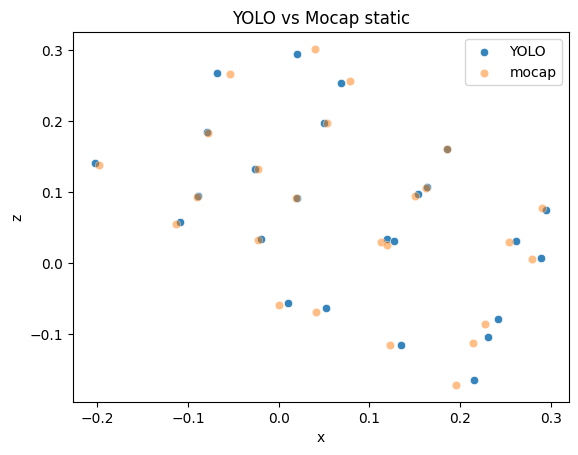

In [32]:
sns.scatterplot(data=mean_ar.to_pandas(), x='x', y='z', label = 'YOLO', alpha = 0.9)
sns.scatterplot(data=mean_mc.to_pandas(), x='x', y='z', label = 'mocap', alpha = 0.5)
plt.title("YOLO vs Mocap static")

In [39]:
err_x = mean_ar['x'] - mean_mc['x'] 
err_z = mean_ar['z'] - mean_mc['z']

Text(0, 0.5, 'x in meters')

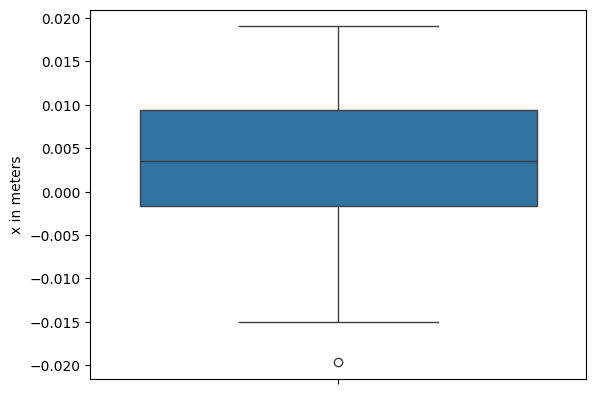

In [44]:
sns.boxplot(data=err_x.to_pandas())
plt.ylabel('x in meters')

Text(0, 0.5, 'z in meters')

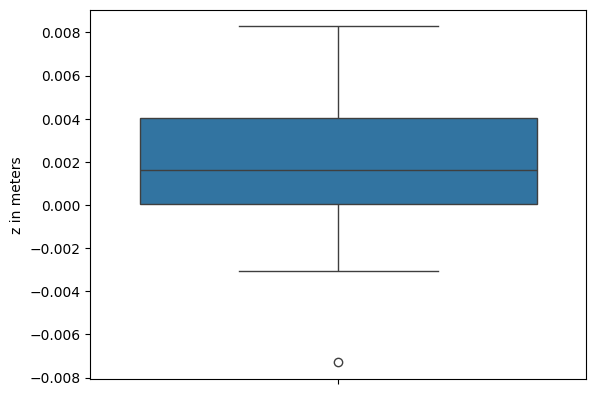

In [45]:
sns.boxplot(data=err_z.to_pandas())
plt.ylabel('z in meters')